## Importing necessary libs

In [29]:
import matplotlib.pyplot as plt
import pickle
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer

## Defining file path

In [30]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'
print(DATA_DIR)

/home/victor/insper/6-sem/ml/ames_AndreVictor/data


## Opening file with cleaned data

In [31]:
clean_data_path = DATA_DIR / 'processed' / 'ames_clean.pkl'

with open(clean_data_path, 'rb') as file:
    data = pickle.load(file)

## Removing outliers

Despite some outliers were already removed on "02_analysis_and_preprocessing.ipynb", by reading the documentation we found this piece of information:

```There are 5 observations that an instructor may wish to remove from the data set before giving it to students (a plot of SALE PRICE versus GR LIV AREA will indicate them quickly). Three of them are true outliers (Partial Sales that likely don�t represent actual market values) and two of them are simply unusual sales (very large houses priced relatively appropriately). I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations) before assigning it to students.```

So let's check if Prof. Ayres has already removed this outliers highlitghed in the documentation.

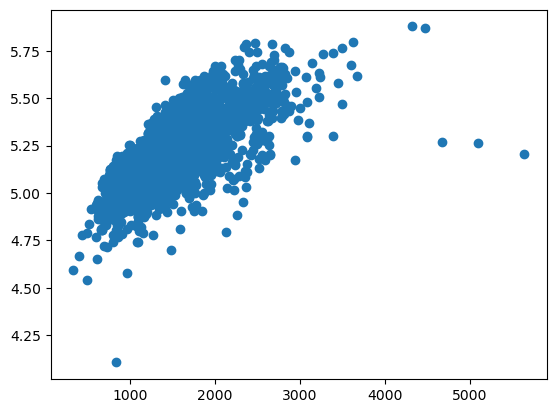

In [32]:
plt.plot(data['Gr.Liv.Area'], data.SalePrice, 'o', alpha=1)
plt.show()


Well, he did not. So let's remove them. 

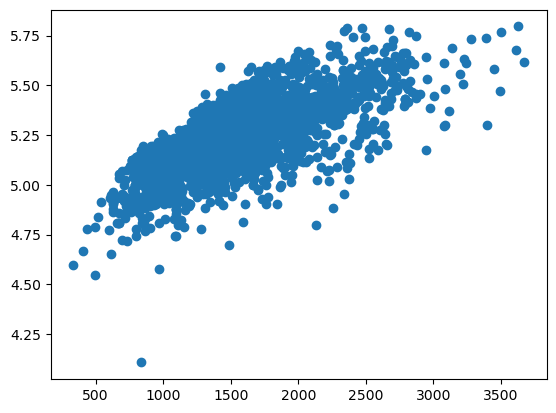

In [33]:
data = data[data['Gr.Liv.Area'] < 4000]

plt.plot(data['Gr.Liv.Area'], data.SalePrice, 'o', alpha=1)
plt.show()

Look's better! Now let's start the data transformation.

## Transforming the data for the model

There are lots of possible data transformations to improve model performance. To understand which ones make sense to AMES dataset, it is necessary to investigate and understand data analysis made in notebook "02_analysis_and_processing.ipynb". One characteristic that stood out from some features was the concentrations to the left in the scatter plots. It may mean that calculating the log of the value can improve correlation with target variable. To check if this is true, it is necessary to select only numerical data. 

In [67]:
continuous_variables = [
    'Lot.Frontage',
    'Lot.Area',
    'Mas.Vnr.Area',
    'BsmtFin.SF.1',
    'BsmtFin.SF.2',
    'Bsmt.Unf.SF',
    'Total.Bsmt.SF',
    'X1st.Flr.SF',
    'X2nd.Flr.SF',
    'Low.Qual.Fin.SF',
    'Gr.Liv.Area',
    'Garage.Area',
    'Wood.Deck.SF',
    'Open.Porch.SF',
    'Enclosed.Porch',
    'X3Ssn.Porch',
    'Screen.Porch',
    'Pool.Area',
    'Misc.Val',
]

continuous_data = data[continuous_variables].copy()
continuous_data

,Lot.Frontage,Lot.Area,Mas.Vnr.Area,BsmtFin.SF.1,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Gr.Liv.Area,Garage.Area,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Misc.Val
0,141.0,31770.0,112.0,639.0,0.0,441.0,1080.0,1656.0,0.0,0.0,1656.0,528.0,210.0,62.0,0.0,0.0,0.0,0.0,0.0
1,80.0,11622.0,0.0,468.0,144.0,270.0,882.0,896.0,0.0,0.0,896.0,730.0,140.0,0.0,0.0,0.0,120.0,0.0,0.0
2,81.0,14267.0,108.0,923.0,0.0,406.0,1329.0,1329.0,0.0,0.0,1329.0,312.0,393.0,36.0,0.0,0.0,0.0,0.0,12500.0
3,93.0,11160.0,0.0,1065.0,0.0,1045.0,2110.0,2110.0,0.0,0.0,2110.0,522.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74.0,13830.0,0.0,791.0,0.0,137.0,928.0,928.0,701.0,0.0,1629.0,482.0,212.0,34.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,37.0,7937.0,0.0,819.0,0.0,184.0,1003.0,1003.0,0.0,0.0,1003.0,588.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0
2926,68.0,8885.0,0.0,301.0,324.0,239.0,864.0,902.0,0.0,0.0,902.0,484.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0
2927,62.0,10441.0,0.0,337.0,0.0,575.0,912.0,970.0,0.0,0.0,970.0,0.0,80.0,32.0,0.0,0.0,0.0,0.0,700.0
2928,77.0,10010.0,0.0,1071.0,123.0,195.0,1389.0,1389.0,0.0,0.0,1389.0,418.0,240.0,38.0,0.0,0.0,0.0,0.0,0.0


Now we can validate our idea. One way to understand if makes sense calculating log values is checking data distribution. It was checked on notebook "02.1_some_more_analysis.ipynb" and it was confirmed that some features have a distribution that can be improved by calculating log values.

#### Go check charts again and come back!

### Checking data distribution

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


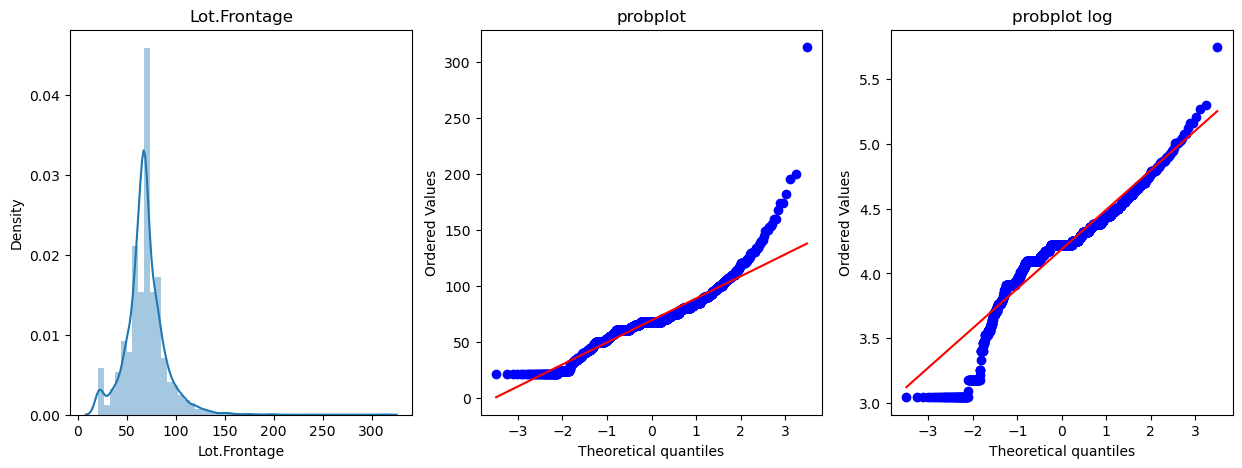

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


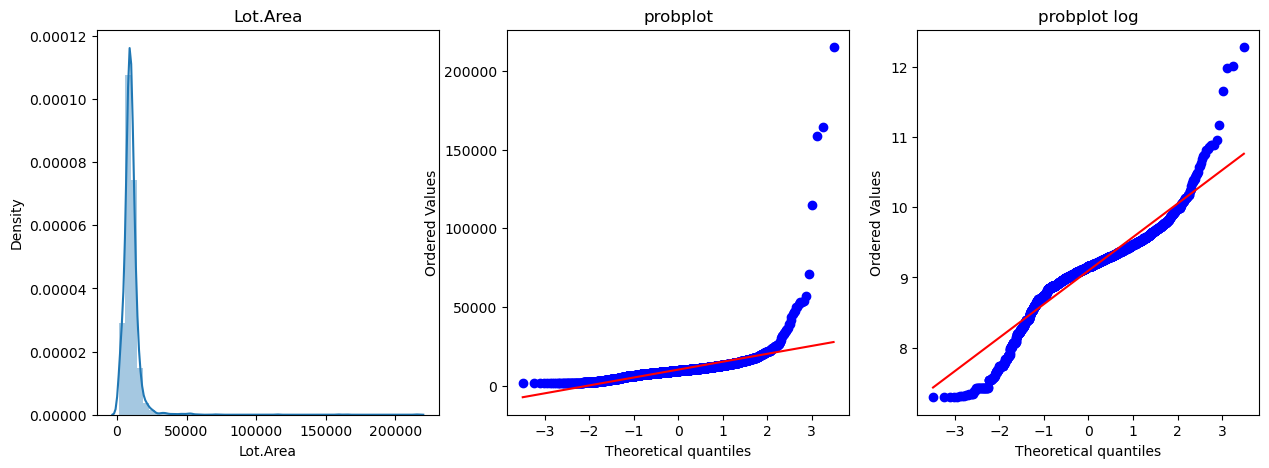

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


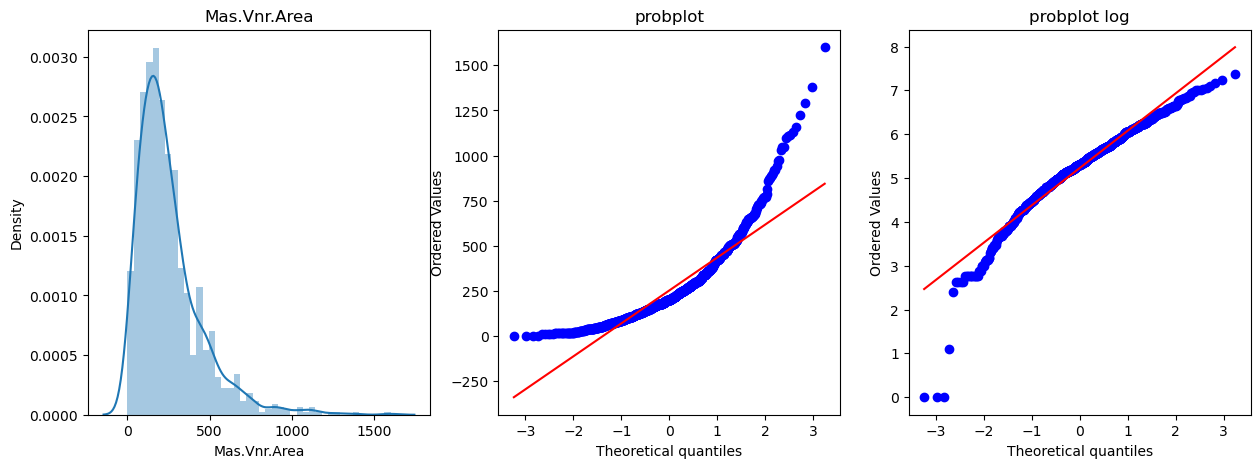

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


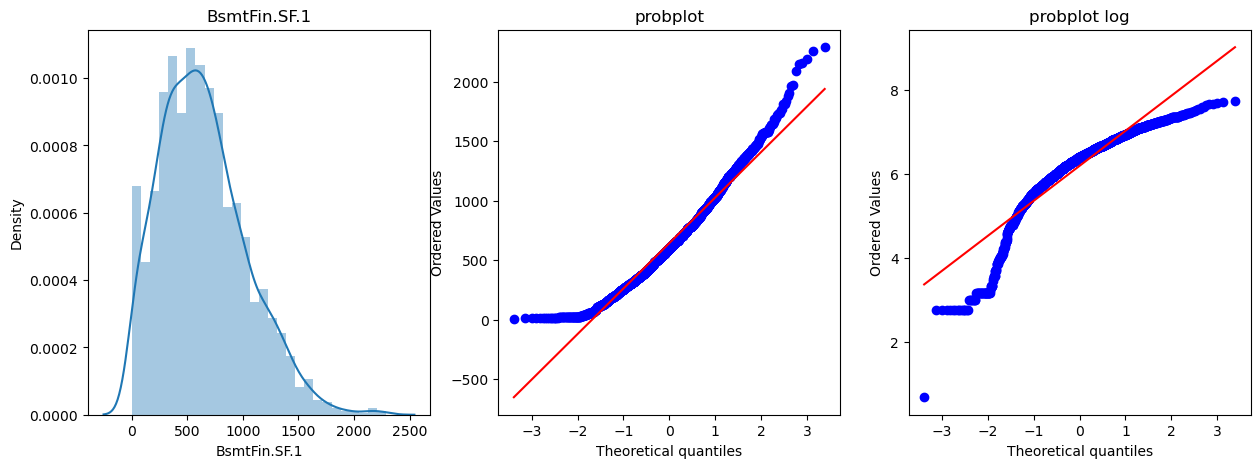

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


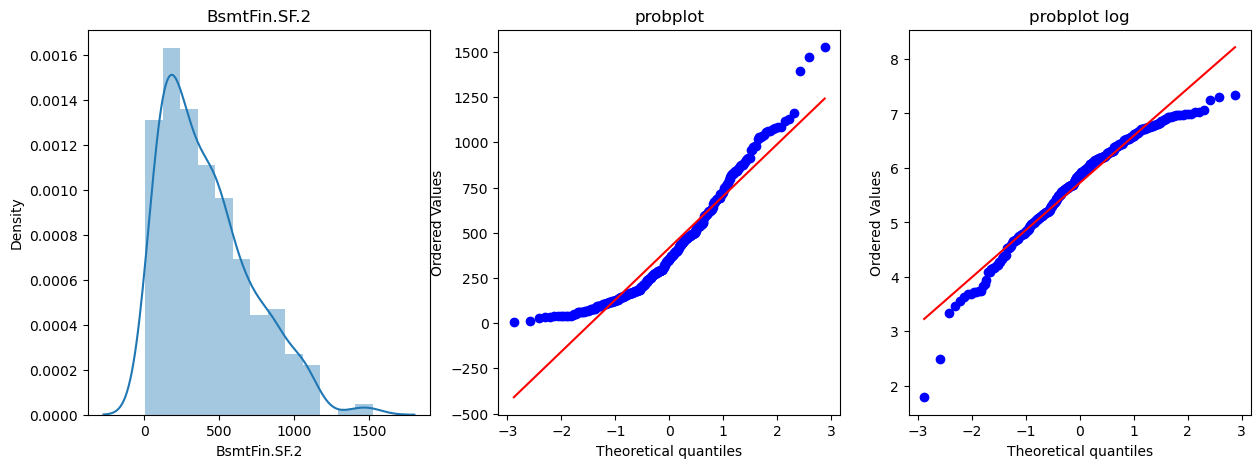

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


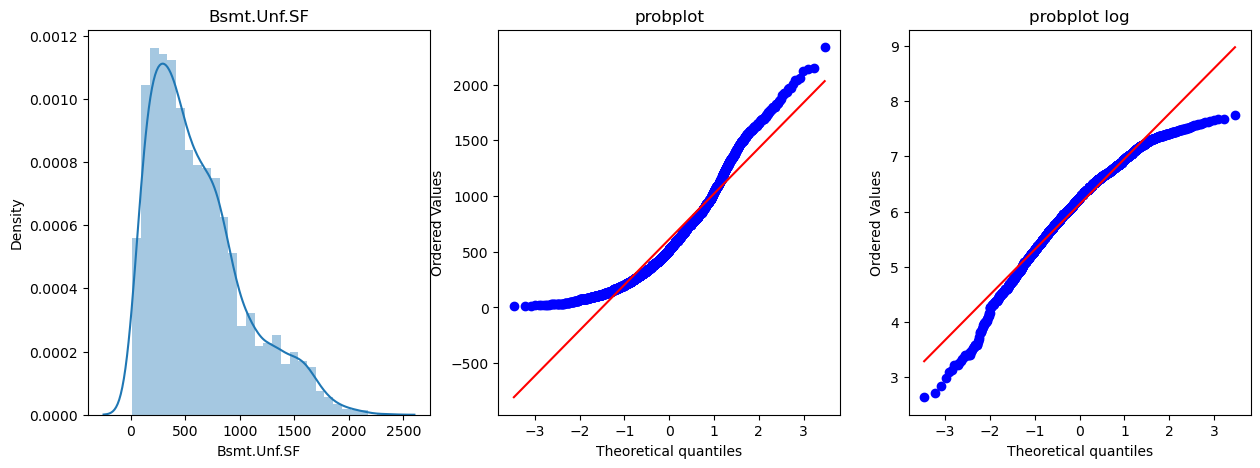

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


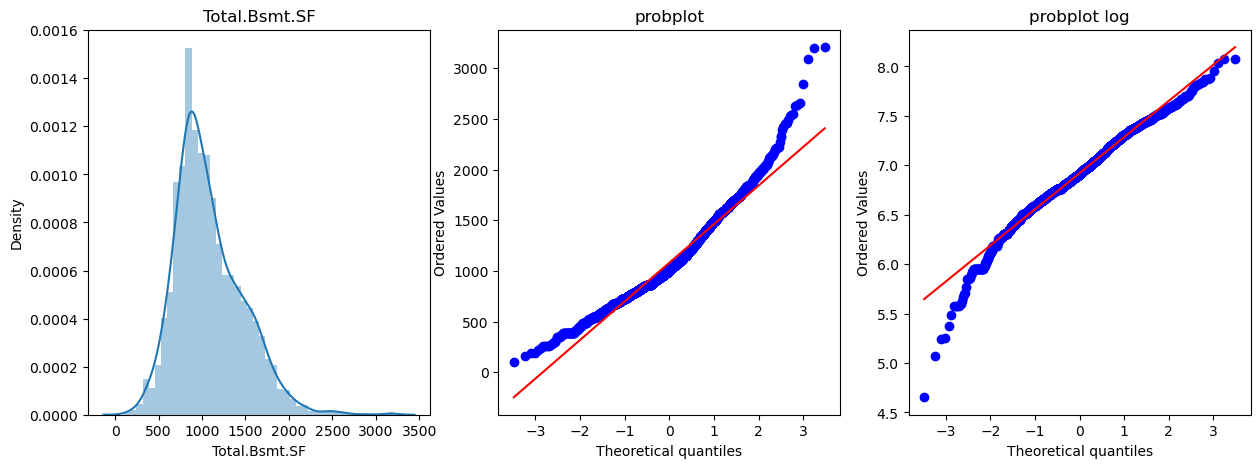

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


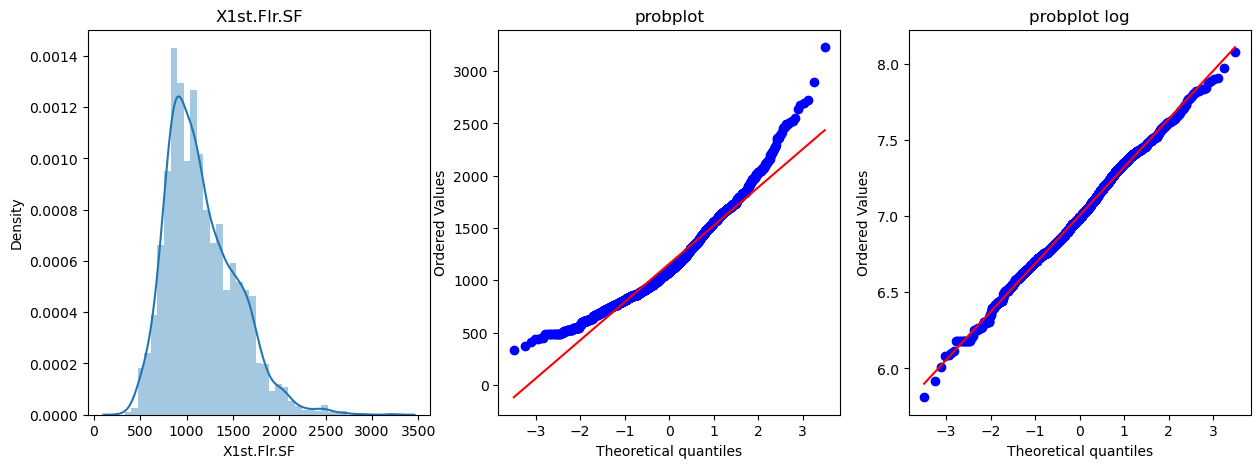

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


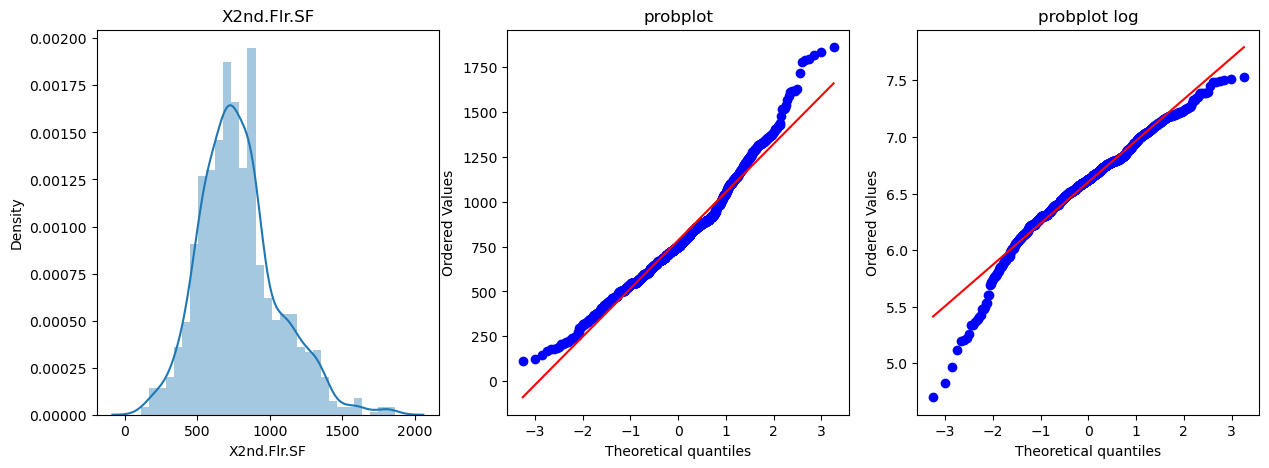

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


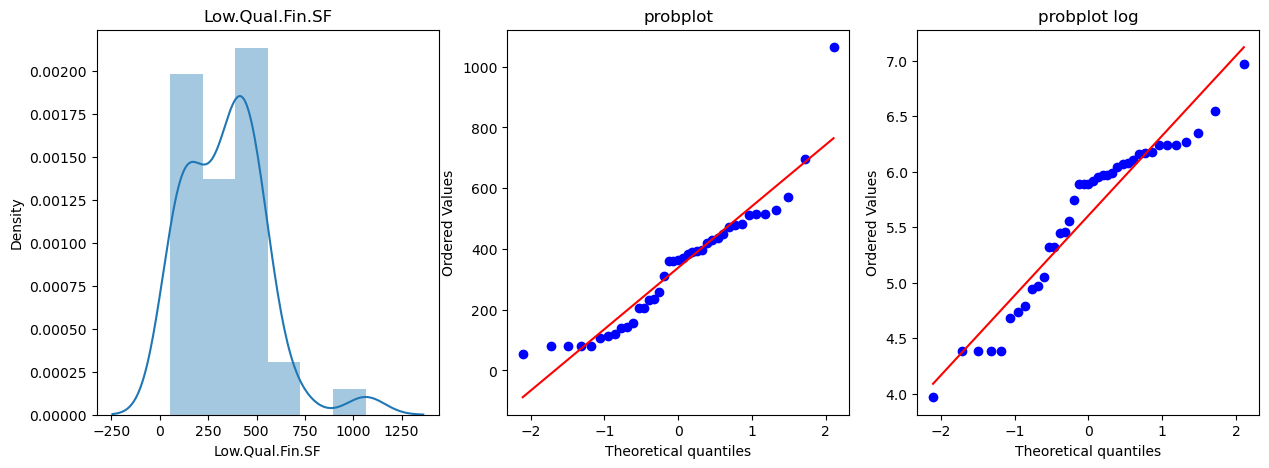

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


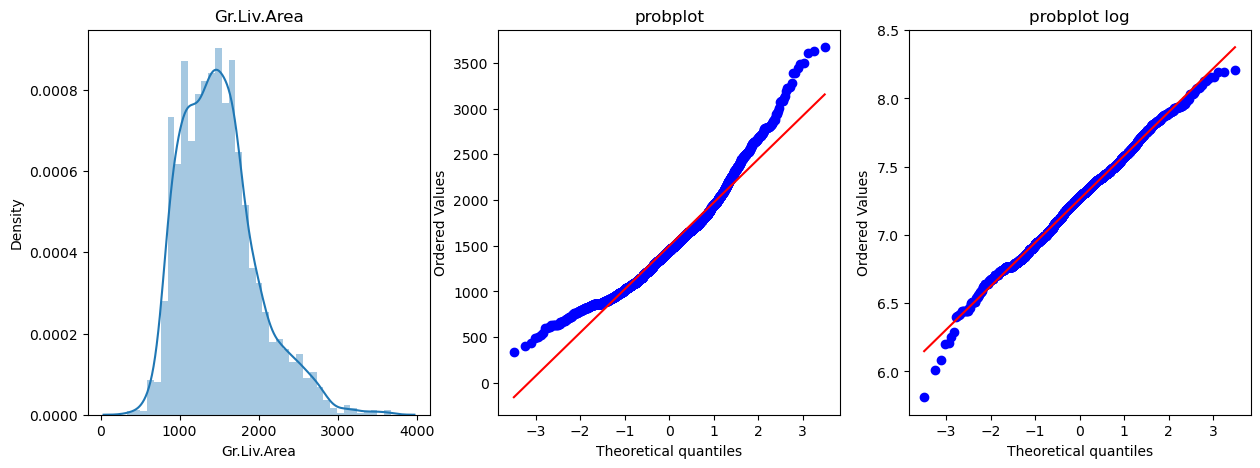

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


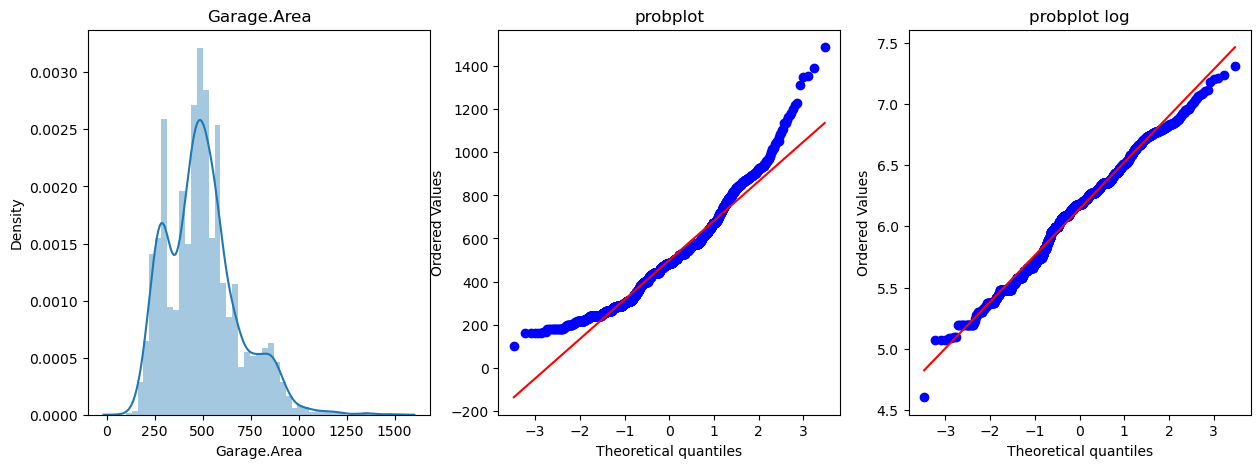

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


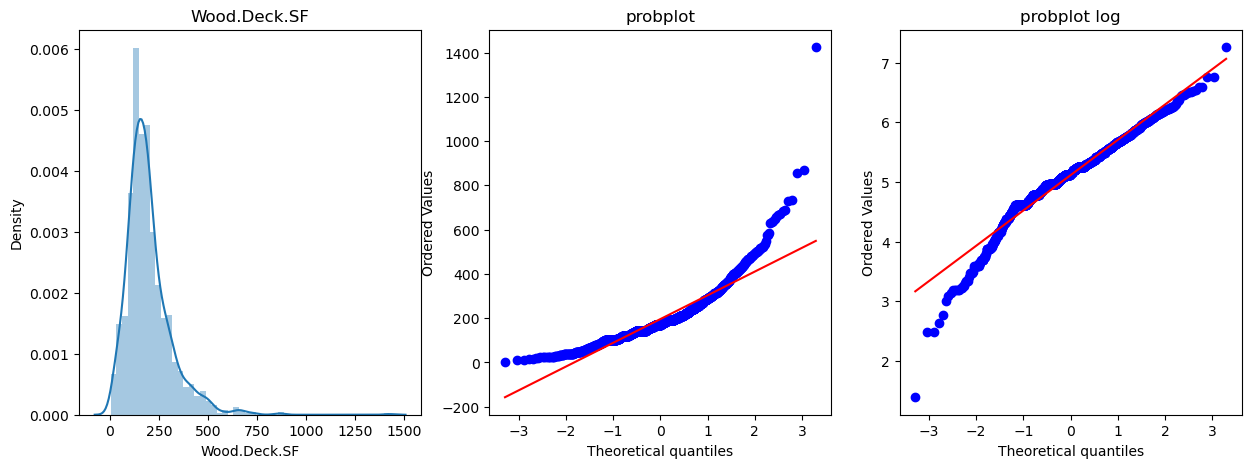

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


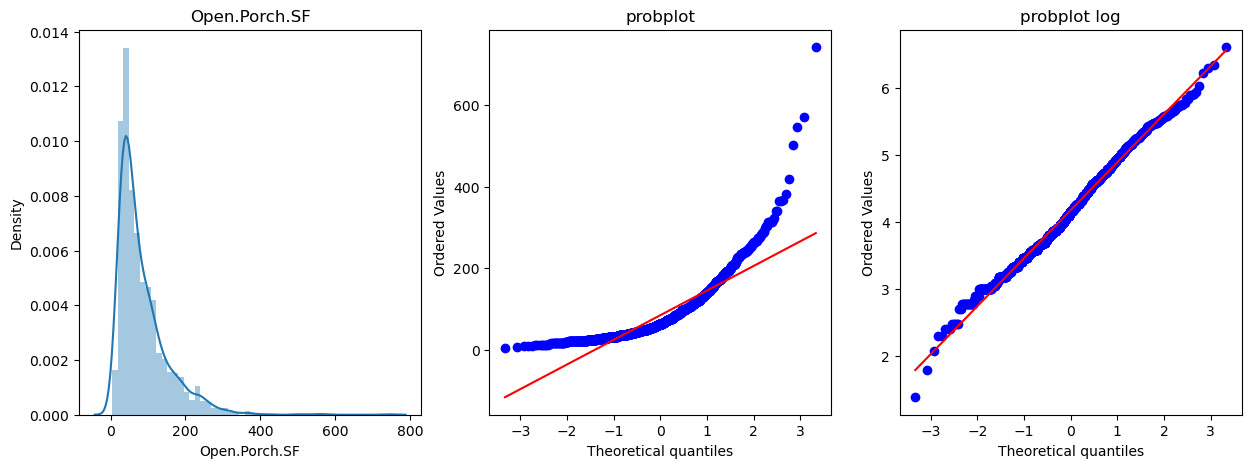

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


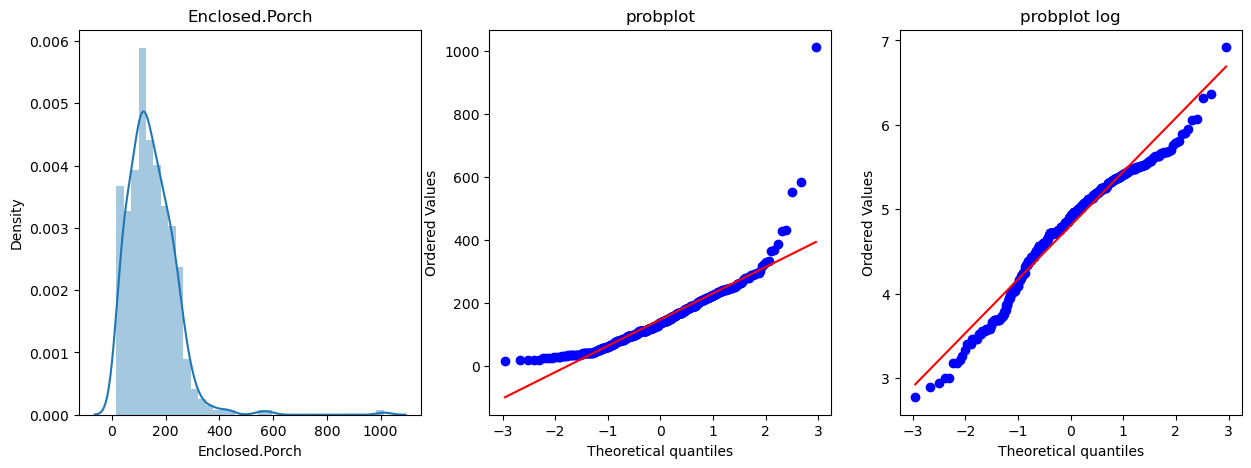

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


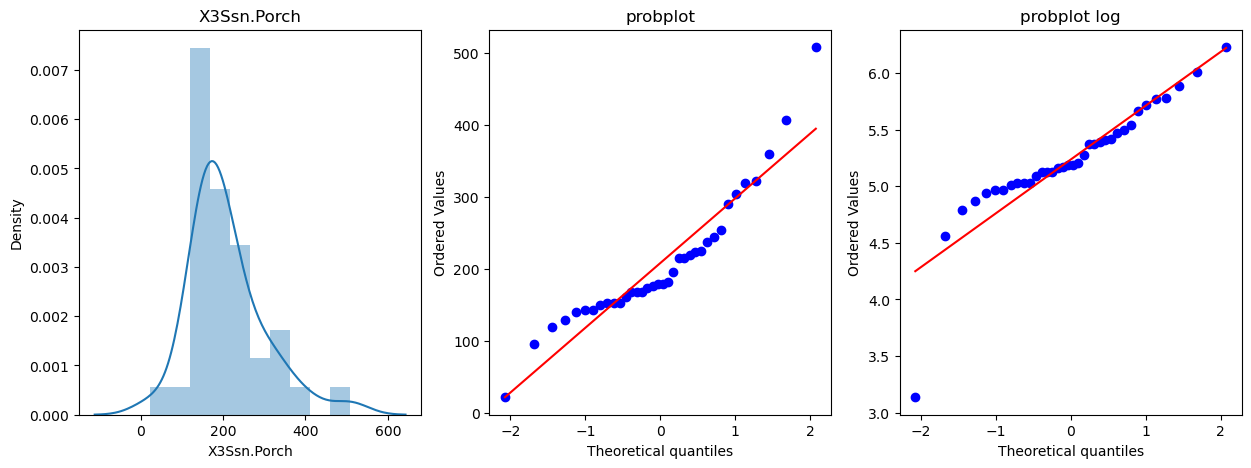

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


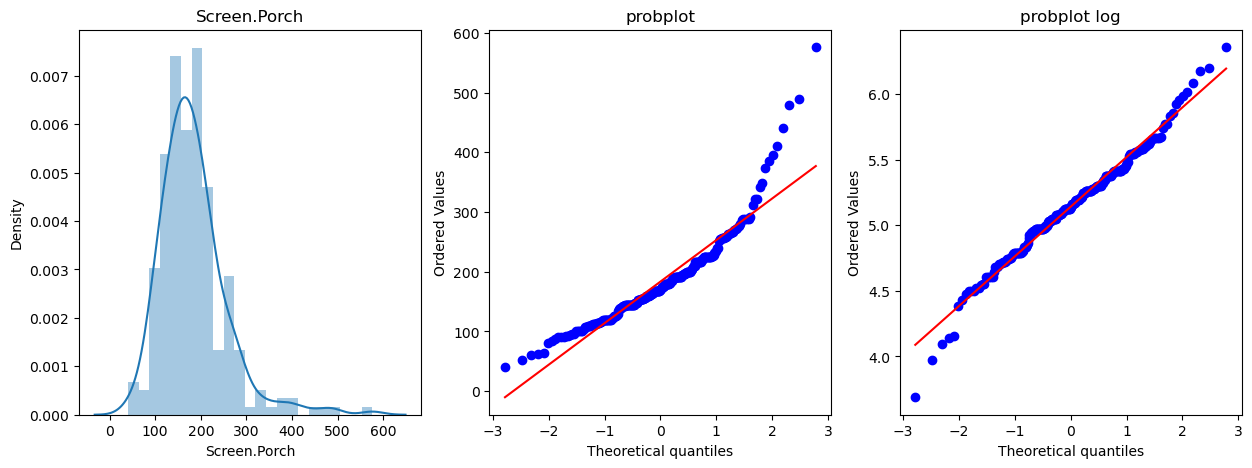

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


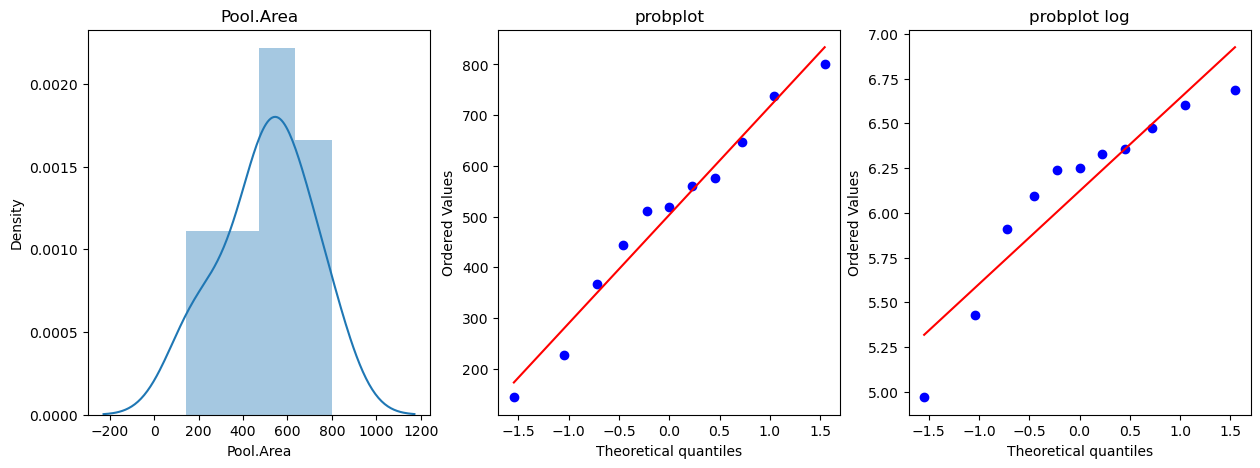

/tmp/ipykernel_239640/2420514429.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(num_nonzero_data[col], ax=ax1)


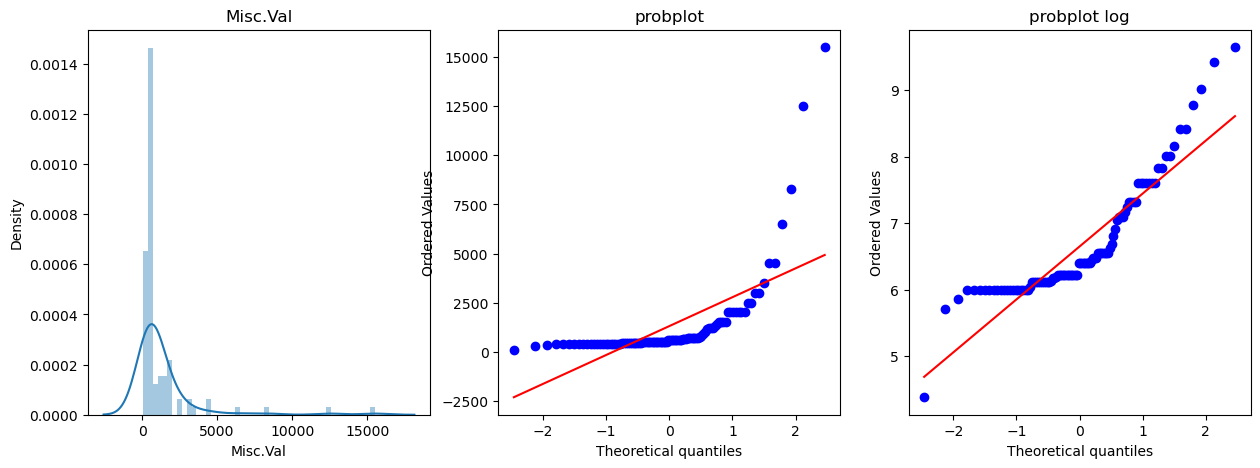

In [65]:
for col in continuous_variables:

    num_nonzero_data = continuous_data[continuous_data[col] != 0]
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    sns.distplot(num_nonzero_data[col], ax=ax1)
    stats.probplot(num_nonzero_data[col], plot=ax2)
    stats.probplot(np.log(num_nonzero_data[col]), plot=ax3)

    ax1.set_title(col)
    ax2.set_title('probplot')
    ax3.set_title('probplot log')
    
    plt.show()

Wow. It seems that our idea was right. We can calculate log values for the features that, by calculating, increase similarity to normal distribution. Other strategy is to calculate log values for all numerical features and check if it improves correlation with target data. Let's do it.

### Checking log correlation

In [7]:
target = data['SalePrice'].copy()

In [68]:
for column, series in continuous_data.items():
    # Calculate correlation between the two columns
    corr = series.corr(target)

    series = series.loc[series != 0]
    log_series = series.apply(np.log)
    corr_log = log_series.corr(target)
    
    if abs(corr_log) > (abs(corr) + 0.05):
        print("Correlation between", column, "and the target is", corr)
        print("Correlation between log("+column+") and the target is", corr_log)
        print()

Correlation between Lot.Area and the target is 0.26899519227320307
Correlation between log(Lot.Area) and the target is 0.3889256823739671

Correlation between BsmtFin.SF.2 and the target is 0.013164869064206686
Correlation between log(BsmtFin.SF.2) and the target is 0.16732899860234482

Correlation between X2nd.Flr.SF and the target is 0.2735671859560301
Correlation between log(X2nd.Flr.SF) and the target is 0.6525540521426112

Correlation between Low.Qual.Fin.SF and the target is -0.04291133806505599
Correlation between log(Low.Qual.Fin.SF) and the target is 0.19839155340570916

Correlation between Enclosed.Porch and the target is -0.13120204891454895
Correlation between log(Enclosed.Porch) and the target is 0.2219024329127324

Correlation between X3Ssn.Porch and the target is 0.040774615803703736
Correlation between log(X3Ssn.Porch) and the target is 0.1158704329894402

Correlation between Screen.Porch and the target is 0.10967674898162444
Correlation between log(Screen.Porch) and th

Yyyyaaaaaayyy! Correlation increases on "Lot.Area", "BsmtFin.SF.2", "X2nd.Flr.SF", "Low.Qual.Fin.SF", "Enclosed.Porch", "X3Ssn.Porch", "Screen.Porch", "Pool.Area" and "Misc.Val" when log is calculated. Let's create a list with features with better correlation and improvement in distribution.

In [69]:
columns_to_log = ['Gr.Liv.Area', 
                  'Lot.Area', 
                  'BsmtFin.SF.2', 
                  'X2nd.Flr.SF',
                  'Low.Qual.Fin.SF', 
                  'Enclosed.Porch', 
                  'X3Ssn.Porch', 
                  'Screen.Porch',
                  'Pool.Area', 
                  'Misc.Val', 
                  'Open.Porch.SF', 
                  'Wood.Deck.SF', 
                  'Garage.Area',
                  'X1st.Flr.SF', 
                  'Total.Bsmt.SF', 
                  'Bsmt.Unf.SF', 
                  'Mas.Vnr.Area']

## Scaling the data

Another great strategy to improve performance on models is to scale the numerical data. This strategy has no effect on models like Decisions Trees, but have a huge impact on linear models like Elastic Net.

Checking boxplot charts, lots of outliers were noticed. If data is scaled by minimum and maximun values, data quality will be impacted because of the effect of outliers. Instead of applying min and max scaling, a better strategy is to apply standard scaler.

# Create data transformation pipeline

In [10]:
num_pipeline = Pipeline([
    ('log_transformer', FunctionTransformer(np.log, validate=True, kw_args={'columns_to_log': columns_to_log})),
    ('std_scaler', StandardScaler()),
])

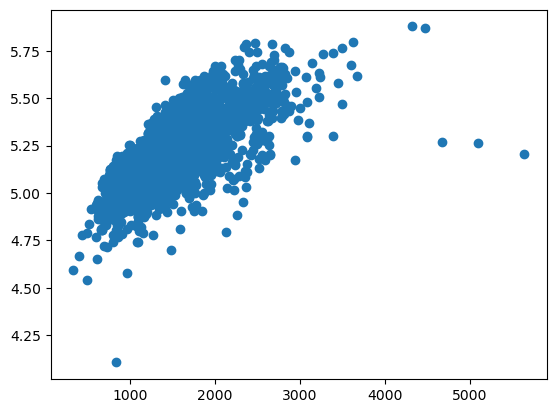